In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.autograd
from torchvision.utils import save_image

In [2]:
#DEVICE = torch.device('cpu')
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 30
BATCH_SIZE = 64

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 32, 32, 3

Device: cuda:0


In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [4]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


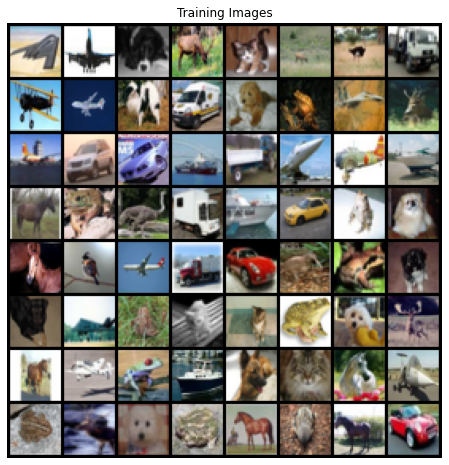

In [5]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

In [6]:
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=32, image_width=32, color_channels=3):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        # self.generator = nn.Sequential(
        #     nn.Linear(latent_dim, 64),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(64, 64),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(64, image_height*image_width*color_channels),
        #     nn.Tanh()
        # )

        # self.discriminator = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(image_height*image_width*color_channels, 64),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(64, 1), # outputs logits
        #     #nn.Sigmoid()
        # )

        ### Current Best Working Version
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(64, 512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, 4096),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Unflatten(1,(256,4,4)),
            nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, 4, stride=2,padding=1),
            nn.Tanh()
        )
          
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*4*4,512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512,64),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64,16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 1), # outputs logits
            #nn.Sigmoid()
        )

        ## Experimental Versions 
        # self.generator = nn.Sequential(
        #     nn.Linear(latent_dim, 64),
        #     nn.LeakyReLU(inplace=True),
            
        #     nn.Linear(64, 512),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Linear(512, 4096),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm1d(4096),
        #     nn.Unflatten(1,(256,4,4)),
        #     nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(128),
        #     nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(64),
        #     nn.ConvTranspose2d(64, 3, 4, stride=2,padding=1),
        #     nn.Tanh()
        # )
          
        # self.discriminator = nn.Sequential(
        #     nn.Conv2d(3, 64, 4, stride=2,padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(64, 128, 4, stride=2,padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(128, 256, 4, stride=2,padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(256),
        #     nn.Flatten(),
        #     nn.Linear(256*4*4,512),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Linear(512,64),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Linear(64,16),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Linear(16, 1), # outputs logits
        #     #nn.Sigmoid()
        # )
        
        
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [7]:
model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [8]:
#TRAINING CODE
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            k = 0
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            if epoch == num_epochs-1:
              for fi in fake_images:
                save_image(fi,f'/content/generated_imgs/fakeimg_{k}.png')
                k+=1
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [9]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_cifar_01.pt')

Epoch: 001/030 | Batch 000/782 | Gen/Dis Loss: 0.5917/0.6988
Epoch: 001/030 | Batch 100/782 | Gen/Dis Loss: 0.9500/0.6151
Epoch: 001/030 | Batch 200/782 | Gen/Dis Loss: 0.8723/0.5945
Epoch: 001/030 | Batch 300/782 | Gen/Dis Loss: 1.2065/0.6432
Epoch: 001/030 | Batch 400/782 | Gen/Dis Loss: 0.8796/0.5724
Epoch: 001/030 | Batch 500/782 | Gen/Dis Loss: 0.8369/0.6967
Epoch: 001/030 | Batch 600/782 | Gen/Dis Loss: 0.8117/0.6508
Epoch: 001/030 | Batch 700/782 | Gen/Dis Loss: 1.0829/0.6146
Time elapsed: 0.53 min
Epoch: 002/030 | Batch 000/782 | Gen/Dis Loss: 0.7563/0.6293
Epoch: 002/030 | Batch 100/782 | Gen/Dis Loss: 0.8429/0.6742
Epoch: 002/030 | Batch 200/782 | Gen/Dis Loss: 0.8979/0.7080
Epoch: 002/030 | Batch 300/782 | Gen/Dis Loss: 0.8275/0.6782
Epoch: 002/030 | Batch 400/782 | Gen/Dis Loss: 0.8659/0.5873
Epoch: 002/030 | Batch 500/782 | Gen/Dis Loss: 0.8624/0.6467
Epoch: 002/030 | Batch 600/782 | Gen/Dis Loss: 0.8722/0.5862
Epoch: 002/030 | Batch 700/782 | Gen/Dis Loss: 1.0573/0.5602
T

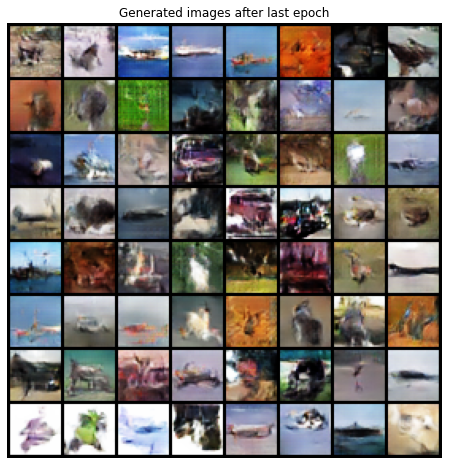

In [10]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()